# Aggregated Well Profiles
In this notebook, single-cell morphological data is aggregated by condition (well) to generate compound profiles.

In [1]:
# load third-party Python modules
import javabridge
import bioformats as bf
import skimage
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import re
import os
import sys
import h5py
import json
from sklearn.manifold import TSNE

javabridge.start_vm(class_path=bf.JARS)

In [2]:
patannot = pd.read_csv('../data/coculture_metafiles/patannot.txt',
                      sep='\t')

In [3]:
# load plate annotation
annot_df = pd.read_csv('../data/AML_trainset/drugannot.txt',
                      sep='\t')

In [4]:
hcl_annot = pd.read_csv('../data/coculture_metafiles/HCL_plate_layout.txt',
                       sep='\t')

In [5]:
hcl_annot.head()

,well,Drug,conc,Culture
0,r01c01,PRT062607,4.5,Mono-culture
1,r01c02,PRT062607,4.5,Co-culture
2,r01c03,DMSO,0.0,Mono-culture
3,r01c04,DMSO,0.0,Co-culture
4,r01c05,PRT062607,0.3,Mono-culture


In [6]:
# load viable cell count data
viabcount = pd.read_table('../data/viable-count.tsv')

In [7]:
viabcount.head()

,plate,well,cellcount_viab,cellcount_apop
0,180306_Plate1,r01c01,-1.354137,0.677863
1,180306_Plate1,r01c02,-0.804466,0.342502
2,180306_Plate1,r01c03,-1.280396,0.382822
3,180306_Plate1,r01c04,-0.136094,1.045533
4,180306_Plate1,r01c05,-2.312758,0.114603


In [8]:
with open('featselect.json') as file:
    featdict = json.load(file)
{k : len(v) for k,v in featdict.items()}

{'repcor': 166, 'residcor': 44, 'uncorr': 6}

In [9]:
feat_sel = ['well'] + featdict['residcor']

In [10]:
prof_dir = '../data/coculture_profiles/'

In [11]:
plates = os.listdir(prof_dir)

In [12]:
data_all = []
for plate in plates:
    imgdf = pd.read_csv(os.path.join(prof_dir, plate))
    X_subset = imgdf[feat_sel].copy()
    count_df = viabcount[viabcount['plate']==plate.replace('.csv', '')]
    count_df = count_df.drop(['plate'], axis=1)
    X_subset = pd.merge(X_subset,
                        count_df,
                        on='well')
    
    if patannot[patannot['plate']== plate.replace('.csv', '')]['Diagnosis'].values[0] == 'HCL':
        plate_df = pd.merge(X_subset, hcl_annot, on='well')
    else:
        plate_df = pd.merge(X_subset, annot_df,on='well')
    mono = plate_df[plate_df['Culture']=='Mono-culture'].drop(['well', 'Culture', 'conc'], axis=1)
    co = plate_df[plate_df['Culture']=='Co-culture'].drop(['well', 'Culture', 'conc'], axis=1)

    mono = mono.groupby(['Drug'], as_index=False).agg('mean')
    co = co.groupby(['Drug'], as_index=False).agg('mean')

    plate_df = pd.merge(mono,co, on='Drug', how='inner')
    plate_df.index = plate_df['Drug']
    plate_df = plate_df.drop(['Drug'], axis=1)
    plate_df['plate'] = plate.replace('.csv', '')
    data_all.append(plate_df)

In [13]:
df_all = pd.concat(data_all)

In [14]:
df_wide = pd.pivot_table(df_all, index=df_all.index, columns='plate')

In [15]:
df_wide = df_wide[df_wide.index != "Vemurafenib"]

/opt/miniconda3/envs/MLnew/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



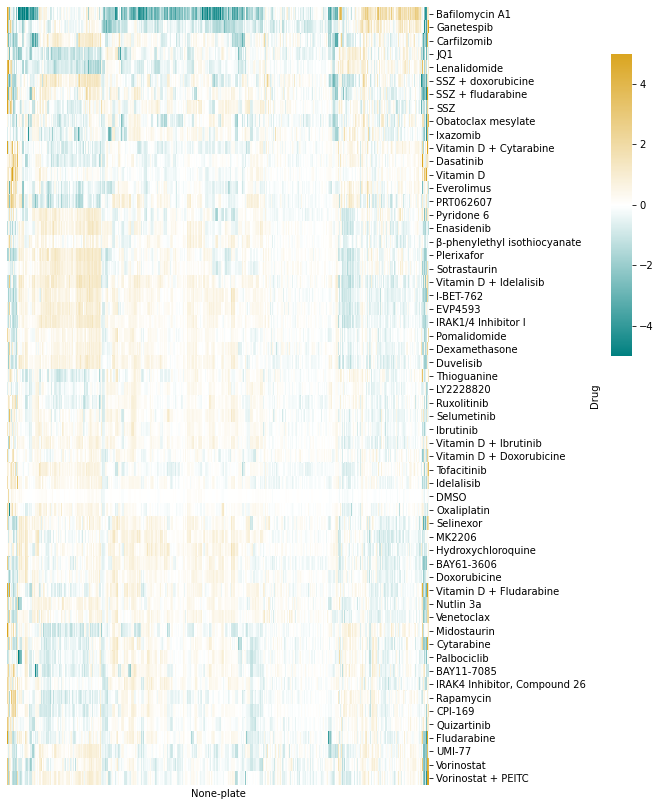

In [16]:
from bioimg.singlecell import plot_heatmap
plot_heatmap(df_wide, xticklabels=False, size=(10,14),
            yticklabels=True, vmin=-5, vmax=5)

Now aggregate by drug and concentration:

In [17]:
data_all = []
for plate in plates:
    imgdf = pd.read_csv(os.path.join(prof_dir, plate))
    X_subset = imgdf[feat_sel].copy()
    
    count_df = viabcount[viabcount['plate']==plate.replace('.csv', '')]
    count_df = count_df.drop(['plate'], axis=1)
    X_subset = pd.merge(X_subset,
                        count_df,
                        on='well')
    
    plate_df = pd.merge(X_subset, annot_df,on='well')
    plate_df['drugconc'] = plate_df['Drug']+"_"+plate_df['conc'].astype(str)
    mono = plate_df[plate_df['Culture']=='Mono-culture'].drop(['well', 'Culture', 'Drug', 'conc'], axis=1)
    co = plate_df[plate_df['Culture']=='Co-culture'].drop(['well', 'Culture', 'Drug', 'conc'], axis=1)

    mono = mono.groupby(['drugconc'], as_index=False).agg('mean')
    co = co.groupby(['drugconc'], as_index=False).agg('mean')

    plate_df = pd.merge(mono,co, on='drugconc', how='inner')
    plate_df.index = plate_df['drugconc']
    plate_df = plate_df.drop(['drugconc'], axis=1)
    plate_df['plate'] = plate.replace('.csv', '')
    data_all.append(plate_df)

In [18]:
df_all = pd.concat(data_all)

In [19]:
#df_wide[df_wide.isna()] = 0

In [20]:
'''plot_heatmap(df_wide, xticklabels=False, size=(10,24),
            yticklabels=True, vmin=-5, vmax=5)'''

'plot_heatmap(df_wide, xticklabels=False, size=(10,24),\n            yticklabels=True, vmin=-5, vmax=5)'

In [21]:
data_all = []
for plate in plates:
    imgdf = pd.read_csv(os.path.join(prof_dir, plate))
    X_subset = imgdf[feat_sel].copy()
    
    count_df = viabcount[viabcount['plate']==plate.replace('.csv', '')]
    count_df = count_df.drop(['plate'], axis=1)
    X_subset = pd.merge(X_subset,
                        count_df,
                        on='well')
    
    if patannot[patannot['plate']== plate.replace('.csv', '')]['Diagnosis'].values[0] == 'HCL':
        plate_df = pd.merge(X_subset, hcl_annot, on='well')
    else:
        plate_df = pd.merge(X_subset, annot_df,on='well')
    plate_df['drugconc'] = plate_df['Drug']+"_"+plate_df['conc'].astype(str)
    mono = plate_df[plate_df['Culture']=='Mono-culture'].drop(['well', 'Culture', 'Drug', 'conc'], axis=1)
    co = plate_df[plate_df['Culture']=='Co-culture'].drop(['well', 'Culture', 'Drug', 'conc'], axis=1)

    mono = mono.groupby(['drugconc'], as_index=False).agg('mean')
    mono.columns = mono.columns + "_M"
    co = co.groupby(['drugconc'], as_index=False).agg('mean')
    co.columns = co.columns + "_C"
    
    mono = mono.rename({"drugconc_M": "drugconc"}, axis=1)
    co = co.rename({"drugconc_C": "drugconc"}, axis=1)

    plate_df = pd.merge(mono,co, on='drugconc', how='inner')
    plate_df.index = plate_df['drugconc']
    plate_df = plate_df.drop(['drugconc'], axis=1)
    plate_df['plate'] = plate.replace('.csv', '')
    data_all.append(plate_df)

In [22]:
df_all = pd.concat(data_all)

In [23]:
df_wide = pd.pivot_table(df_all, index=df_all.index, columns='plate')
df_wide.columns = df_wide.columns.map('|'.join)

In [24]:
# write aggregated profiles to a file
# df_wide.to_csv('../data/all_profiles_coculture.csv')